## Setup


In [13]:
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import glob

# tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

# keras
import keras
from keras.layers import Input, Dense, Conv2D, Dropout, Activation, Flatten, Reshape, Softmax, MaxPooling2D
from keras.models import Model, Sequential, clone_model
from tensorflow.keras.optimizers import Adam
from keras.datasets import mnist, cifar10, cifar100
print(keras.__version__)

# pytorch
import torch
import torchvision
print(torch.__version__)

# scikit-learn
import sklearn
from sklearn import cluster, decomposition, manifold
import pandas as pd

cwd = ''

2.5.0
2.5.0
1.8.0


### Load Dataset

In [15]:
'''
Load Cifar10 images and labels
'''
(x_train, x_label), (x_test, x_test_label) = cifar10.load_data()
x_train.shape

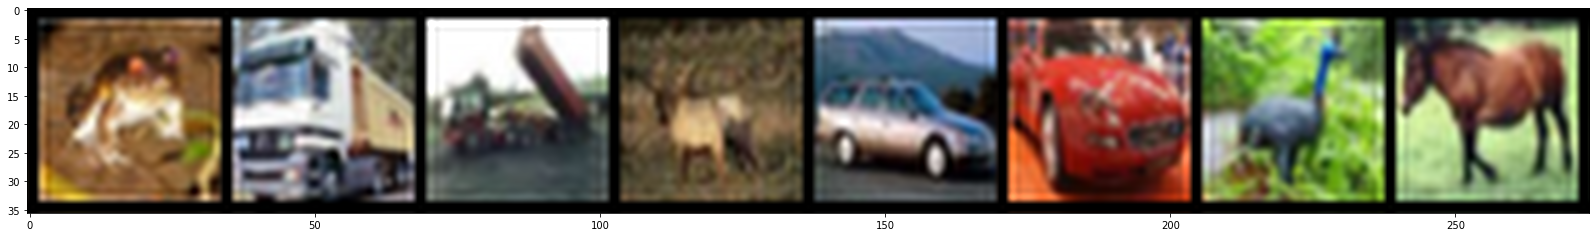

(50000, 10)

In [ ]:
def get_label_vector(labels):
    '''
    Convert label into vector form
    Example:
    input: [1, 2]
    output: [[0,1,0], [0,0,1]]
    '''
    label_vectors = np.zeros((len(labels), np.max(labels)+1))
    for i in range(len(labels)):
        label_vectors[i, labels[i]] = 1
    return label_vectors

def get_image_grid(images_np, nrow=8):
    '''
    Helper method for display images
    '''
    images_torch = [torch.from_numpy(x) for x in images_np]
    torch_grid = torchvision.utils.make_grid(images_torch, nrow)
    return torch_grid.numpy()

def plot_image_grid(images_np, nrow =8, factor=20, interpolation='lanczos'):
    '''
    Display images
    images_np: images in shape [batch, height, width, channel]
    '''
    images_np = np.swapaxes(np.swapaxes(images_np, 1, 3), 2,3)
    n_channels = max(x.shape[0] for x in images_np)
    images_np = [x if (x.shape[0] == n_channels) else np.concatenate([x, x, x], axis=0) for x in images_np]
    grid = get_image_grid(images_np, nrow)
    plt.figure(figsize=(len(images_np) + factor, 12 + factor))
    if images_np[0].shape[0] == 1:
        plt.imshow(grid[0], cmap='gray', interpolation=interpolation)
    else:
        plt.imshow(grid.transpose(1, 2, 0), interpolation=interpolation)
    plt.show()

plot_image_grid(x_train[:8])
x_label, x_test_label = get_label_vector(x_label), get_label_vector(x_test_label)
x_label.shape

### Target Model

In [ ]:
def build_cnn(input_shape, class_num):
    '''
    Build a convolutional neural network
    '''
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('tanh'))
    # model.add(Dropout(0.2))
    model.add(Dense(class_num))
    model.add(Softmax())

    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

target_model = build_cnn(x_train[0].shape, 10)

In [ ]:
target_model.fit(x=x_train[:10000], y=x_label[:10000], batch_size=64, epochs=100, verbose=False)

In [ ]:
target_model.evaluate(x=x_test, y=x_test_label)

313/313 [==============================] - 2s 4ms/step - loss: 3.1243 - accuracy: 0.5529


[3.124260187149048, 0.5529000163078308]

### Shadow Model

In [ ]:
shadow_model = build_cnn(x_train[0].shape, 10)
shadow_model.fit(x=x_train[10000:20000], y=x_label[10000:20000], batch_size=64, epochs=20, verbose=False)

In [ ]:
shadow_model.evaluate(x=x_train[10000:20000], y=x_label[10000:20000], batch_size=64)
shadow_model.evaluate(x=x_train[:10000], y=x_label[:10000], batch_size=64)

157/157 [==============================] - 1s 4ms/step - loss: 2.0737 - accuracy: 0.5406


[2.0737061500549316, 0.5406000018119812]

### Attack Model

In [ ]:
def model_outputs(in_data, in_labels, model, class_num):
    '''
    Get the outputs from the classification model, concatenate with the label vector
    input: image shape (h, w, 3 (1))
    output: classification vector (batch, class_num*2)
    '''
    batch = 10000
    output = np.zeros((1, class_num*2))
    for i in range(0, len(in_data), batch):
        new_out = np.concatenate((model.predict(in_data[i:i+batch]), in_labels[i:i+batch]), axis=1)
        output = np.concatenate((output, new_out))
    return np.array(output[1:])

def get_att_data(in_data, out_data):
    '''
    Assign IN/OUT labels to the data and shuffle the data
    input: in_data/out_data shape (batch, class_num*2)
    output: (batch*2, class_num*2), (batch*2,)
    '''
    in_label = [1.0]*len(in_data)
    out_label = [0.0]*len(out_data)
    labels = in_label + out_label
    in_data = [d for d in in_data]
    out_data = [d for d in out_data]
    data = in_data + out_data

    c = list(zip(data, labels))
    random.shuffle(c)
    data, labels = zip(*c)
    return np.array(data), np.array(labels)

in_outputs = model_outputs(x_train[10000:20000], x_label[10000:20000], shadow_model, 10)
out_outputs = model_outputs(x_test, x_test_label, shadow_model, 10)
data, labels = get_att_data(in_outputs, out_outputs)
data.shape, labels.shape

In [ ]:
def build_att():
    '''
    Build a multi-layer perceptron for attacking
    '''
    model = Sequential()
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2))
    model.add(Softmax())
    opt = keras.optimizers.Adam(learning_rate=0.001)
    precision = keras.metrics.Precision(class_id=0)
    recall = keras.metrics.Recall(class_id=0)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', precision, recall])
    return model

attack_model = build_att()
label_vec = get_label_vector(np.array(labels, dtype=np.int))
attack_model.fit(x=data, y=label_vec, batch_size=64, epochs=10)

In [ ]:
in_outputs = model_outputs(x_train[:10000], x_label[:10000], target_model, 10)
out_outputs = model_outputs(x_test[:10000], x_test_label[:10000], target_model, 10)
data, labels = get_att_data(in_outputs, out_outputs)
label_vec = get_label_vector(np.array(labels, dtype=np.int))

In [ ]:
attack_model.evaluate(x=data, y=label_vec)

625/625 [==============================] - 3s 4ms/step - loss: 0.4248 - accuracy: 0.7951 - precision: 1.0000 - recall: 0.5903


[0.4248450696468353, 0.7951499819755554, 1.0, 0.5903000235557556]

## Experiments: 


1.   In the first experiment, we want to demonstrate how overfitting affects the accuracy of the attack model.  

1.   In the second experiment, we want to show the effect of the size of the training dataset on the accuracy of the attack model. We will consider both the target model's training size and the attack model's training size. 

2.   In the last experiment, we want to compare the accuracy of the attack model for two types of "in" training data: one that has been used early on in the training of the target model and one that has been used later when the model has converged. If the accuracy varies across such training data, does the learning rate affect the difference?





In [ ]:
def run_experiment(target_epoch, train_data, train_label, test_data, test_label,
                   target_data_size=10000, attack_data_size=10000, attack_epoch=15, class_num=10):
    target_model = build_cnn(train_data[0].shape, class_num)
    target_model.fit(x=train_data[:target_data_size], 
                     y=train_label[:target_data_size], 
                     batch_size=64, epochs=target_epoch, verbose=False)
    target_train_acc = target_model.evaluate(x=train_data[:target_data_size], 
                                             y=train_label[:target_data_size])[1]
    target_test_acc = target_model.evaluate(x=test_data, y=test_label)[1]

    shadow_model = build_cnn(train_data[0].shape, class_num)
    shadow_model.fit(x=train_data[target_data_size:target_data_size*2], 
                     y=train_label[target_data_size:target_data_size*2], 
                     batch_size=64, epochs=target_epoch, verbose=False)
    in_outputs = model_outputs(train_data[target_data_size:target_data_size+attack_data_size//2], 
                               train_label[target_data_size:target_data_size+attack_data_size//2], 
                               shadow_model, class_num)
    out_outputs = model_outputs(test_data[:attack_data_size//2], 
                                test_label[:attack_data_size//2], 
                                shadow_model, class_num)
    data, labels = get_att_data(in_outputs, out_outputs)
    attack_model = build_att()
    label_vec = get_label_vector(np.array(labels, dtype=np.int))
    attack_model.fit(x=data, y=label_vec, batch_size=64, epochs=attack_epoch, verbose=False)

    in_outputs = model_outputs(x_train[:attack_data_size//2], 
                               x_label[:attack_data_size//2], 
                               target_model, class_num)
    out_outputs = model_outputs(x_test[:attack_data_size//2], 
                                x_test_label[:attack_data_size//2], 
                                target_model, class_num)
    data, labels = get_att_data(in_outputs, out_outputs)
    label_vec = get_label_vector(np.array(labels, dtype=np.int))
    loss, att_acc, acc_prec, acc_reca = attack_model.evaluate(x=data, y=label_vec)
    return target_train_acc, target_test_acc, att_acc, acc_prec, acc_reca

In [ ]:
df = pd.DataFrame()

### Experiment 1: how overfitting affects the accuracy of the attack model

In [ ]:
target_train_acc, target_test_acc = [],[]
att_acc, att_prec, att_reca = [],[],[]
for epoch in range(10, 101, 10):
    print('Epoch: ', epoch)
    ta, tt, aa, ap, ar = run_experiment(target_epoch=epoch, train_data=x_train, 
                                        train_label=x_label, test_data=x_test, 
                                        test_label=x_test_label)
    target_train_acc.append(ta)
    target_test_acc.append(tt)
    att_acc.append(aa)
    att_prec.append(ap)
    att_reca.append(ar)

Epoch:  10
313/313 [==============================] - 1s 3ms/step - loss: 0.6476 - accuracy: 0.6945 - precision_43: 0.6837 - recall_43: 0.7240
Epoch:  20
313/313 [==============================] - 1s 3ms/step - loss: 0.2769 - accuracy: 0.9035 - precision_44: 0.9535 - recall_44: 0.8484
Epoch:  30
313/313 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9594 - precision_45: 0.9862 - recall_45: 0.9318
Epoch:  40
313/313 [==============================] - 1s 3ms/step - loss: 0.1640 - accuracy: 0.9543 - precision_46: 0.9712 - recall_46: 0.9364
Epoch:  50
313/313 [==============================] - 1s 2ms/step - loss: 5.0667 - accuracy: 0.1875


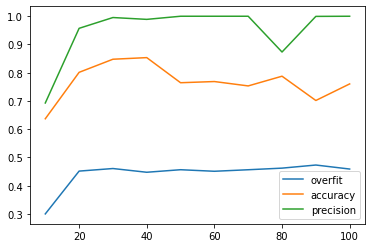

,Epoch,Target Train Accuracy on Epoch,Target Test Accuracy on Epoch,Overfit,Attack Accuracy on Epoch,Attack Precision on Epoch,Attack Recall on Epoch
0,10,0.8413,0.5412,0.3001,0.6370,0.692849,0.4922
1,20,0.9987,0.5470,0.4517,0.8014,0.957221,0.6310
2,30,1.0000,0.5392,0.4608,0.8478,0.995442,0.6988
3,40,1.0000,0.5524,0.4476,0.8535,0.988935,0.7150
4,50,1.0000,0.5434,0.4566,0.7646,1.000000,0.5292
5,60,1.0000,0.5489,0.4511,0.7688,1.000000,0.5376
6,70,1.0000,0.5435,0.4565,0.7533,1.000000,0.5066
7,80,1.0000,0.5378,0.4622,0.7877,0.873345,0.6730
8,90,0.9995,0.5263,0.4732,0.7017,0.999505,0.4036
9,100,1.0000,0.5410,0.4590,0.7604,1.000000,0.5208


In [ ]:
overfit = np.array(target_train_acc) - np.array(target_test_acc)
epochs = range(10, 101, 10)
plt.plot(epochs, overfit, label='overfit')
plt.plot(epochs, att_acc, label='accuracy')
plt.plot(epochs, att_prec, label='precision')
plt.legend()
plt.show()

df['Epoch'] = epochs
df['Target Train Accuracy on Epoch'] = target_train_acc
df['Target Test Accuracy on Epoch'] = target_test_acc
df['Overfit'] = overfit
df['Attack Accuracy on Epoch'] = att_acc
df['Attack Precision on Epoch'] = att_prec
df['Attack Recall on Epoch'] = att_reca
df.head(10)

### Experiment 2: show the effect of the size of the training dataset on the accuracy of the attack model

In [ ]:
att_acc, att_prec, att_reca = [],[],[]
target_train_acc, target_test_acc = [],[]
for train_size in range(2500, 25001, 2500):
    print('Training Size: ', train_size)
    ta, tt, aa, ap, ar = run_experiment(target_epoch=20, train_data=x_train, 
                                        train_label=x_label, test_data=x_test, 
                                        test_label=x_test_label, 
                                        target_data_size=train_size)
    target_train_acc.append(ta)
    target_test_acc.append(tt)
    att_acc.append(aa)
    att_prec.append(ap)
    att_reca.append(ar)

Training Size:  2500
313/313 [==============================] - 1s 3ms/step - loss: 0.6314 - accuracy: 0.6616 - precision_20: 0.6469 - recall_20: 0.7116
Training Size:  5000
313/313 [==============================] - 1s 3ms/step - loss: 0.3759 - accuracy: 0.8328 - precision_21: 0.9559 - recall_21: 0.6978
Training Size:  7500
313/313 [==============================] - 1s 3ms/step - loss: 0.4166 - accuracy: 0.8060 - precision_22: 0.9286 - recall_22: 0.6630
Training Size:  10000
313/313 [==============================] - 1s 3ms/step - loss: 0.4240 - accuracy: 0.8007 - precision_23: 0.9087 - recall_23: 0.6686
Training Size:  12500
313/313 [==============================] - 1s 3ms/step - loss: 0.4779 - accuracy: 0.7695 - precision_24: 0.9060 - recall_24: 0.6014
Training Size:  15000
313/313 [==============================] - 1s 3ms/step - loss: 0.5201 - accuracy: 0.7438 - precision_25: 0.8305 - recall_25: 0.6126
Training Size:  17500
313/313 [==============================] - 1s 3ms/step - 

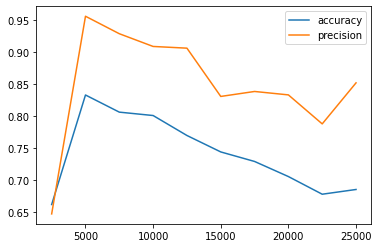

,Epoch,Target Train Accuracy on Epoch,Target Test Accuracy on Epoch,Overfit,Attack Accuracy on Epoch,Attack Precision on Epoch,Attack Recall on Epoch,Target Training Size,Attack Accuracy on TTS,Attack Precision on TTS,Attack Recall on TTS,Target Train Accuracy on TTS,Target Test Accuracy on TTS,Overfit on TTS
0,10,0.8413,0.5412,0.3001,0.6370,0.692849,0.4922,2500,0.6616,0.646909,0.7116,0.991200,0.4568,0.534400
1,20,0.9987,0.5470,0.4517,0.8014,0.957221,0.6310,5000,0.8328,0.955890,0.6978,0.999400,0.5181,0.481300
2,30,1.0000,0.5392,0.4608,0.8478,0.995442,0.6988,7500,0.8060,0.928571,0.6630,0.998933,0.5406,0.458333
3,40,1.0000,0.5524,0.4476,0.8535,0.988935,0.7150,10000,0.8007,0.908671,0.6686,0.999300,0.5393,0.460000
4,50,1.0000,0.5434,0.4566,0.7646,1.000000,0.5292,12500,0.7695,0.905996,0.6014,0.991120,0.5418,0.449320


In [ ]:
train_sizes = range(2500, 25001, 2500)
plt.plot(train_sizes, att_acc, label='accuracy')
plt.plot(train_sizes, att_prec, label='precision')
plt.legend()
plt.show()

overfit = np.array(target_train_acc) - np.array(target_test_acc)
df['Target Training Size'] = train_sizes
df['Target Train Accuracy on TTS'] = target_train_acc
df['Target Test Accuracy on TTS'] = target_test_acc
df['Overfit on TTS'] = overfit
df['Attack Accuracy on TTS'] = att_acc
df['Attack Precision on TTS'] = att_prec
df['Attack Recall on TTS'] = att_reca
df.head()

Shadow Data Size:  2500
79/79 [==============================] - 1s 3ms/step - loss: 0.4552 - accuracy: 0.7840 - precision_30: 0.8901 - recall_30: 0.6480
Shadow Data Size:  5000
157/157 [==============================] - 1s 3ms/step - loss: 0.4442 - accuracy: 0.7816 - precision_31: 0.9484 - recall_31: 0.5956
Shadow Data Size:  7500
235/235 [==============================] - 1s 3ms/step - loss: 0.4497 - accuracy: 0.7819 - precision_32: 0.9449 - recall_32: 0.5987
Shadow Data Size:  10000
313/313 [==============================] - 1s 3ms/step - loss: 0.4605 - accuracy: 0.7745 - precision_33: 0.9455 - recall_33: 0.5826
Shadow Data Size:  12500
391/391 [==============================] - 1s 3ms/step - loss: 0.4202 - accuracy: 0.8028 - precision_34: 0.9486 - recall_34: 0.6403
Shadow Data Size:  15000
469/469 [==============================] - 2s 3ms/step - loss: 0.4477 - accuracy: 0.7890 - precision_35: 0.8778 - recall_35: 0.6715
Shadow Data Size:  17500
547/547 [=============================

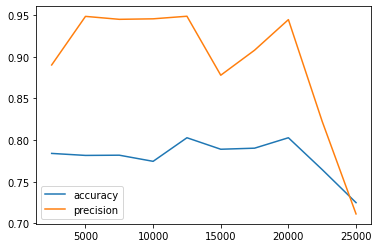

In [ ]:
att_acc, att_prec, att_reca = [],[],[]
target_train_acc, target_test_acc = [],[]
for shadow_size in range(2500, 25001, 2500):
    print('Shadow Data Size: ', shadow_size)
    ta, tt, aa, ap, ar = run_experiment(target_epoch=20, train_data=x_train, 
                                        train_label=x_label, test_data=x_test, 
                                        test_label=x_test_label, 
                                        attack_data_size=shadow_size)
    target_train_acc.append(ta)
    target_test_acc.append(tt)
    att_acc.append(aa)
    att_prec.append(ap)
    att_reca.append(ar)

train_sizes = range(2500, 25001, 2500)
overfit = np.array(target_train_acc) - np.array(target_test_acc)
plt.plot(train_sizes, att_acc, label='accuracy')
plt.plot(train_sizes, att_prec, label='precision')
plt.legend()
plt.show()

df['Shadow Training Size'] = train_sizes
df['Target Train Accuracy on STS'] = target_train_acc
df['Target Test Accuracy on STS'] = target_test_acc
df['Overfit on STS'] = overfit
df['Attack Accuracy on STS'] = att_acc
df['Attack Precision on STS'] = att_prec
df['Attack Recall on STS'] = att_reca
df.to_csv(cwd + 'cifar10_results.csv', index=False)

### Experiment 3

In [ ]:
target_model = build_cnn(x_train[0].shape, 10)
target_model.fit(x=x_train[:1000], y=x_label[:1000], batch_size=64, epochs=20, verbose=False)
target_model.fit(x=x_train[-1000:], y=x_label[-1000:], batch_size=64, epochs=20, verbose=False)

shadow_model = build_cnn(x_train[0].shape, 10)
shadow_model.fit(x=x_train[1000:2000], y=x_label[1000:2000], batch_size=64, epochs=20, verbose=False)

in_outputs = model_outputs(x_train[1000:2000], x_label[1000:2000], shadow_model, 10)
out_outputs = model_outputs(x_test[:1000], x_test_label[:1000], shadow_model, 10)
data, labels = get_att_data(in_outputs, out_outputs)
attack_model = build_att()
label_vec = get_label_vector(np.array(labels, dtype=np.int))
attack_model.fit(x=data, y=label_vec, batch_size=64, epochs=20, verbose=False)

in_outputs = model_outputs(x_train[:1000], x_label[:1000], target_model, 10)
out_outputs = model_outputs(x_test[:1000], x_test_label[:1000], target_model, 10)
data, labels = get_att_data(in_outputs, out_outputs)
label_vec = get_label_vector(np.array(labels, dtype=np.int))
attack_model.evaluate(x=data, y=label_vec)

in_outputs = model_outputs(x_train[-1000:], x_label[-1000:], target_model, 10)
out_outputs = model_outputs(x_test[-1000:], x_test_label[-1000:], target_model, 10)
data, labels = get_att_data(in_outputs, out_outputs)
label_vec = get_label_vector(np.array(labels, dtype=np.int))
attack_model.evaluate(x=data, y=label_vec)

63/63 [==============================] - 0s 3ms/step - loss: 0.3221 - accuracy: 0.8810 - precision_42: 0.9847 - recall_42: 0.7740


[0.3220728635787964,
 0.8809999823570251,
 0.9847328066825867,
 0.7739999890327454]